# Imports
Importing necessary modules

In [1]:
!pip install -q matplotlib numpy torch FrEIA tqdm scikit-learn

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.9 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.1 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 30.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.1 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 84.2 MB/s eta 0:00:00:00:0100:01
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pylibcugraph-cu12 24.12.0 requires pylibraft-cu12==24.12.*, but you have pylibraft-cu12 25.2.0 which is incompatible.
pylibcugraph-cu12 24.12.0 

# Datageneration and storage
Basically we are making 6 gaussian clusters each with separate color

Using device: cuda
Generated data: x_data shape: (10000000, 2), y_data shape: (10000000, 6)
Saved data to x_train.csv and y_train.csv.
Saved cluster plot to clusters.png


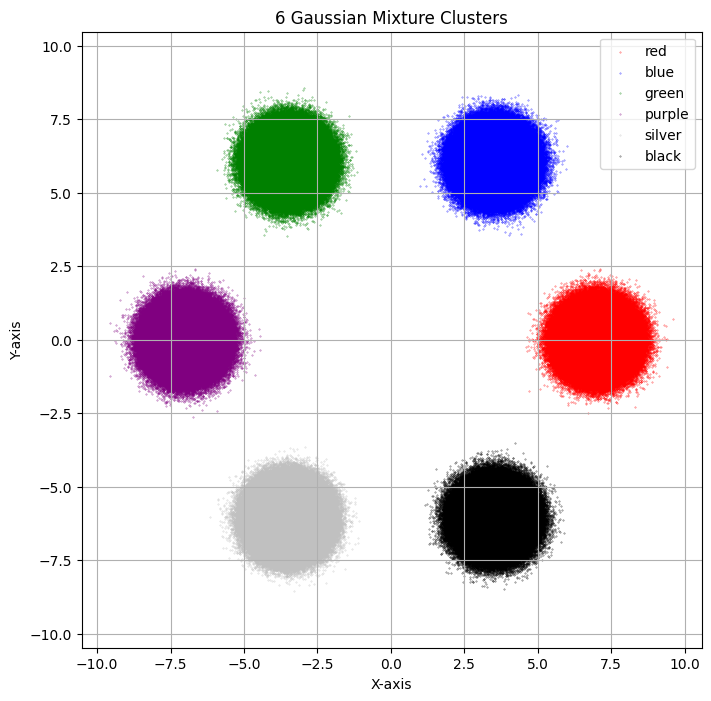

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import OneHotEncoder
import os
import torch


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

def generate_mixture_data(n_samples=2**18, n_clusters=6, radius=7.0, std_dev=0.5):
    angles = np.linspace(0, 2 * np.pi, n_clusters, endpoint=False)
    centers = np.stack([np.cos(angles), np.sin(angles)], axis=1) * radius
    data = []
    labels_int = []

    for _ in range(n_samples):
        comp = np.random.randint(0, n_clusters)
        x = np.random.randn(2) * std_dev + centers[comp]
        label = comp
        data.append(x)
        labels_int.append(label)
    data = np.array(data).astype(np.float32)
    labels_int = np.array(labels_int).reshape(-1, 1)
    encoder = OneHotEncoder(sparse_output=False, categories='auto')
    labels_onehot = encoder.fit_transform(labels_int).astype(np.float32)

    return data, labels_onehot

# Cluster plotting
def plot_clusters(data, labels_onehot, filename='clusters.png'):
    n_clusters = labels_onehot.shape[1]
    all_colors = ['red', 'blue', 'green', 'purple', 'silver', 'black',
                  'orange', 'pink', 'brown', 'cyan', 'magenta', 'yellow']
    if n_clusters > len(all_colors):
        colors = plt.cm.viridis(np.linspace(0, 1, n_clusters))
        print(f"Warning: More clusters ({n_clusters}) than predefined colors ({len(all_colors)}). Using colormap.")
    else:
        colors = all_colors[:n_clusters]
    color_names = [c if isinstance(c, str) else f'Cluster {i}' for i, c in enumerate(colors)]
    plt.figure(figsize=(8, 8))
    for i in range(n_clusters):
        mask = labels_onehot[:, i] == 1
        plt.scatter(data[mask, 0], data[mask, 1], c=[colors[i]], label=color_names[i], s=0.1, alpha=0.7)
    plt.title(f'{n_clusters} Gaussian Mixture Clusters')
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    plt.legend()
    plt.grid(True)
    plt.axis('equal')
    plt.savefig(filename)
    print(f"Saved cluster plot to {filename}")
    plt.show()

if __name__ == "__main__":
    N_SAMPLES = 10**7
    N_CLUSTERS = 6

    x_data, y_data = generate_mixture_data(n_samples=N_SAMPLES, n_clusters=N_CLUSTERS)
    print(f"Generated data: x_data shape: {x_data.shape}, y_data shape: {y_data.shape}")
    x_filename = "x_train.csv"
    y_filename = "y_train.csv"
    plot_filename = "clusters.png"
    if os.path.exists(x_filename) or os.path.exists(y_filename):
       print(f"Warning: {x_filename} or {y_filename} already exists. Overwriting.")

    np.savetxt(x_filename, x_data, delimiter=",", fmt="%.6f")
    np.savetxt(y_filename, y_data, delimiter=",", fmt="%d")
    print(f"Saved data to {x_filename} and {y_filename}.")
    plot_clusters(x_data, y_data, filename=plot_filename)


# Model and training
We are using a different MMD from the one given in paper. We are using a subnet (function s and t) as the one given in function subnet_fc and we have 6 reversible blocks. 

In [3]:
from time import time
import torch.nn as nn
import torch.optim
from FrEIA.framework import InputNode, OutputNode, Node, ReversibleGraphNet
from FrEIA.modules import GLOWCouplingBlock, PermuteRandom
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm

# Dimensions
ndim_tot = 16
ndim_x = 2
ndim_y = 6
ndim_z = 2

def subnet_fc(c_in, c_out):
    return nn.Sequential(nn.Linear(c_in, 512), nn.ReLU(),
                         nn.Linear(512,  c_out))

# Build model
nodes = [InputNode(ndim_tot, name='input')]
for k in range(6):
    nodes.append(Node(nodes[-1], GLOWCouplingBlock,
                      {'subnet_constructor': subnet_fc, 'clamp': 2.0},
                      name=f'coupling_{k}'))
    nodes.append(Node(nodes[-1], PermuteRandom, {'seed': k}, name=f'permute_{k}'))
nodes.append(OutputNode(nodes[-1], name='output'))

model = ReversibleGraphNet(nodes, verbose=False).to(device)

# Losses
def MMD_multiscale(x, y):
    xx, yy, zz = torch.mm(x, x.t()), torch.mm(y, y.t()), torch.mm(x, y.t())
    rx, ry = xx.diag().unsqueeze(0).expand_as(xx), yy.diag().unsqueeze(0).expand_as(yy)
    dxx = rx.t() + rx - 2. * xx
    dyy = ry.t() + ry - 2. * yy
    dxy = rx.t() + ry - 2. * zz

    XX, YY, XY = torch.zeros_like(xx), torch.zeros_like(yy), torch.zeros_like(zz)
    for a in [0.05, 0.2, 0.9]:
        XX += a**2 * (a**2 + dxx)**-1
        YY += a**2 * (a**2 + dyy)**-1
        XY += a**2 * (a**2 + dxy)**-1
    return torch.mean(XX + YY - 2. * XY)

def fit(input, target):
    return torch.mean((input - target) ** 2)

loss_backward = MMD_multiscale
loss_latent = MMD_multiscale
loss_fit = fit

# Hyperparameters
n_epochs = 80
batch_size = 8192*2
learning_rate = 1e-4
n_its_per_epoch = 100
zeros_noise_scale = 0.01
y_noise_scale = 0.1
lambd_predict = 1.0
lambd_latent = 0.1
lambd_rev = 1.0

# Dataset
x_tensor = torch.tensor(x_data, dtype=torch.float32).to(device)
y_tensor = torch.tensor(y_data, dtype=torch.float32).to(device)
train_loader = DataLoader(TensorDataset(x_tensor, y_tensor), batch_size=batch_size, shuffle=True)

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
def train(i_epoch):
    model.train()
    l_tot, batch_idx = 0, 0
    loss_factor = min(1., 2. * 0.002 ** (1. - (float(i_epoch) / n_epochs)))

    for x, y in train_loader:
        batch_idx += 1
        if batch_idx > n_its_per_epoch:
            break
        x, y = x.to(device), y.to(device)

        # Get actual batch size
        current_batch_size = x.shape[0]

        y_clean = y.clone()

        # Forward direction
        pad_x = zeros_noise_scale * torch.randn(current_batch_size, ndim_tot - ndim_x, device=device)
        pad_yz = zeros_noise_scale * torch.randn(current_batch_size, ndim_tot - ndim_y - ndim_z, device=device)
        y += y_noise_scale * torch.randn(current_batch_size, ndim_y, device=device)

        x_input = torch.cat((x, pad_x), dim=1)
        y_input = torch.cat((torch.randn(current_batch_size, ndim_z, device=device), pad_yz, y), dim=1)

        optimizer.zero_grad()
        output = model(x_input)
        if isinstance(output, tuple):
            output = output[0]

        y_short = torch.cat((y_input[:, :ndim_z], y_input[:, -ndim_y:]), dim=1)
        l = lambd_predict * loss_fit(output[:, ndim_z:], y_input[:, ndim_z:])
        output_block_grad = torch.cat((output[:, :ndim_z], output[:, -ndim_y:].detach()), dim=1)
        l += lambd_latent * loss_latent(output_block_grad, y_short)
        l.backward()

        # Reverse direction
        pad_yz = zeros_noise_scale * torch.randn(current_batch_size, ndim_tot - ndim_y - ndim_z, device=device)
        y_rev = y_clean + y_noise_scale * torch.randn(current_batch_size, ndim_y, device=device)
        orig_z_perturbed = output[:, :ndim_z].detach() + y_noise_scale * torch.randn(current_batch_size, ndim_z, device=device)
        y_rev = torch.cat((orig_z_perturbed, pad_yz, y_rev), dim=1)
        y_rev_rand = torch.cat((torch.randn(current_batch_size, ndim_z, device=device), pad_yz, y_rev[:, -ndim_y:]), dim=1)

        output_rev = model(y_rev, rev=True)
        output_rev_rand = model(y_rev_rand, rev=True)
        if isinstance(output_rev, tuple): output_rev = output_rev[0]
        if isinstance(output_rev_rand, tuple): output_rev_rand = output_rev_rand[0]

        l_rev = lambd_rev * loss_factor * loss_backward(output_rev_rand[:, :ndim_x], x[:, :ndim_x])
        l_rev += lambd_predict * loss_fit(output_rev, x_input)
        l_rev.backward()

        for p in model.parameters():
            if p.grad is not None:
                p.grad.data.clamp_(-15.0, 15.0)

        optimizer.step()
        l_tot += l.item() + l_rev.item()

    return l_tot / batch_idx


# Run training
for epoch in tqdm(range(n_epochs)):
    loss = train(epoch)
    if epoch % 20 == 0 or epoch == n_epochs - 1:
        print(f"Epoch {epoch + 1}/{n_epochs} - Loss: {loss:.6f}")

torch.save(model.state_dict(), 'trained_inn.pth')
print("Model saved to 'trained_inn.pth'")


  1%|          | 1/100 [00:39<1:05:34, 39.75s/it]

Epoch 1/100 - Loss: 1.666951


 21%|██        | 21/100 [13:40<51:39, 39.24s/it] 

Epoch 21/100 - Loss: 0.211745


 41%|████      | 41/100 [26:43<38:29, 39.14s/it]

Epoch 41/100 - Loss: 0.014017


 61%|██████    | 61/100 [39:46<25:29, 39.22s/it]

Epoch 61/100 - Loss: 0.011645


 81%|████████  | 81/100 [52:50<12:24, 39.18s/it]

Epoch 81/100 - Loss: 0.007648


100%|██████████| 100/100 [1:05:14<00:00, 39.15s/it]

Epoch 100/100 - Loss: 0.007493
Model saved to 'trained_inn.pth'


# Loading the saved model for evaluation
We load the model for evaluation purpose

In [4]:
from FrEIA.framework import InputNode, OutputNode, Node, ReversibleGraphNet
from FrEIA.modules import GLOWCouplingBlock, PermuteRandom
import torch.nn as nn

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Using device:", device)
# Dimensions (must match training)
ndim_tot = 16
ndim_x = 2
ndim_y = 6
ndim_z = 2

# Define subnet constructor
def subnet_fc(c_in, c_out):
    return nn.Sequential(
        nn.Linear(c_in, 512),
        nn.ReLU(),
        nn.Linear(512, c_out)
    )

# Build INN model
nodes = [InputNode(ndim_tot, name='input')]
for k in range(6):
    nodes.append(Node(nodes[-1], GLOWCouplingBlock,
                      {'subnet_constructor': subnet_fc, 'clamp': 2.0},
                      name=f'coupling_{k}'))
    nodes.append(Node(nodes[-1], PermuteRandom, {'seed': k}, name=f'permute_{k}'))
nodes.append(OutputNode(nodes[-1], name='output'))

model = ReversibleGraphNet(nodes, verbose=False).to(device)

# Load the trained weights
model.load_state_dict(torch.load('trained_inn.pth', map_location=device))
model.eval()


Using device: cuda


/tmp/ipykernel_31/3775300388.py:33: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('trained_inn.pth', map_location=device))


ReversibleGraphNet(
  (module_list): ModuleList(
    (0): GLOWCouplingBlock(
      (subnet1): Sequential(
        (0): Linear(in_features=8, out_features=512, bias=True)
        (1): ReLU()
        (2): Linear(in_features=512, out_features=16, bias=True)
      )
      (subnet2): Sequential(
        (0): Linear(in_features=8, out_features=512, bias=True)
        (1): ReLU()
        (2): Linear(in_features=512, out_features=16, bias=True)
      )
    )
    (1): PermuteRandom()
    (2): GLOWCouplingBlock(
      (subnet1): Sequential(
        (0): Linear(in_features=8, out_features=512, bias=True)
        (1): ReLU()
        (2): Linear(in_features=512, out_features=16, bias=True)
      )
      (subnet2): Sequential(
        (0): Linear(in_features=8, out_features=512, bias=True)
        (1): ReLU()
        (2): Linear(in_features=512, out_features=16, bias=True)
      )
    )
    (3): PermuteRandom()
    (4): GLOWCouplingBlock(
      (subnet1): Sequential(
        (0): Linear(in_features=

# Infer x function
This is the standard forward pass function in which you input the coordinates and the network tells you the color of the point.

In [5]:
import torch
import torch.nn.functional as F

# Infer x from the model : just like normal neural networks.
def infer_x(model, x_input, zeros_noise_scale=0.01, return_logits=False):
    model.eval()

    with torch.no_grad():
        # Convert input to tensor and ensure batch shape
        if not isinstance(x_input, torch.Tensor):
            x_input = torch.tensor(x_input, dtype=torch.float32)
        if len(x_input.shape) == 1:
            x_input = x_input.unsqueeze(0)

        x_input = x_input.to(device)
        batch_size = x_input.shape[0]

        # Pad x with small noise
        pad_x = zeros_noise_scale * torch.randn(batch_size, ndim_tot - ndim_x, device=device)
        x_padded = torch.cat((x_input, pad_x), dim=1)

        # Forward pass
        output = model(x_padded)
        if isinstance(output, tuple):
            output = output[0]

        # Extract the y prediction (last ndim_y dims)
        y_pred_raw = output[:, -ndim_y:]

        # Get one-hot prediction
        max_indices = torch.argmax(y_pred_raw, dim=1)
        y_pred_one_hot = F.one_hot(max_indices, num_classes=ndim_y).float()

        if return_logits:
            return y_pred_one_hot, y_pred_raw
        return y_pred_one_hot


# Infer y function
We have 2 infer_y functions:\
*1*: Infer_y_1 takes one x_input and y_input and tells you the P(x_input|y_input).\
*2*: Infer_y_2 generates new points be sampling new *z* ~ N(0,1) and then getting X = {$x_i$:i $i \in [n]$}.

In [6]:
def infer_y_1(model, y_onehot, x_target, n_samples=1000, zeros_noise_scale=0.01):
    model.eval()
    if not isinstance(y_onehot, torch.Tensor):
        y_onehot = torch.tensor(y_onehot, dtype=torch.float32)
    if not isinstance(x_target, torch.Tensor):
        x_target = torch.tensor(x_target, dtype=torch.float32)
    y_onehot = y_onehot.to(device).repeat(n_samples, 1)
    x_target = x_target.to(device).unsqueeze(0).repeat(n_samples, 1)
    pad_yz = zeros_noise_scale * torch.randn(n_samples, ndim_tot - ndim_y - ndim_z, device=device)
    z_samples = torch.randn(n_samples, ndim_z, device=device)
    y_rev = torch.cat((z_samples, pad_yz, y_onehot), dim=1)
    with torch.no_grad():
        x_samples = model(y_rev, rev=True)
        if isinstance(x_samples, tuple):
            x_samples = x_samples[0]
    x_generated = x_samples[:, :ndim_x]
    distances = torch.norm(x_generated - x_target, dim=1)
    kde = torch.exp(-distances**2 / (2 * 0.1**2))
    p_x_given_y = kde.mean().item()
    return x_generated.cpu().numpy(), p_x_given_y


In [7]:
y_test_samples = [[1, 0, 0, 0, 0, 0],[0, 1, 0, 0, 0, 0],[0, 0, 1, 0, 0, 0],[0, 0, 0, 1, 0, 0],[0, 0, 0, 0, 1, 0],[0, 0, 0, 0, 0, 1]]
x_test_samples = [[7.234,-0.1234],[3.0,6.0],[-3.0, 6.0],[-7.5,0.1],[-3.0,-6.0],[3.0,-6.0]]
for y_test in y_test_samples:
    print("Testing with y", y_test)
    for x_test in x_test_samples:
        x_samples, px_given_y = infer_y_1(model, y_test, x_test)
        print(f"Estimated p(x|y): {px_given_y:.6f} for x_test: {x_test}")
    print('-'*25)
    print('\n')

Testing with y [1, 0, 0, 0, 0, 0]
Estimated p(x|y): 0.033095 for x_test: [7.234, -0.1234]
Estimated p(x|y): 0.000000 for x_test: [3.0, 6.0]
Estimated p(x|y): 0.000000 for x_test: [-3.0, 6.0]
Estimated p(x|y): 0.000000 for x_test: [-7.5, 0.1]
Estimated p(x|y): 0.000000 for x_test: [-3.0, -6.0]
Estimated p(x|y): 0.000000 for x_test: [3.0, -6.0]
-------------------------


Testing with y [0, 1, 0, 0, 0, 0]
Estimated p(x|y): 0.000000 for x_test: [7.234, -0.1234]
Estimated p(x|y): 0.029942 for x_test: [3.0, 6.0]
Estimated p(x|y): 0.000000 for x_test: [-3.0, 6.0]
Estimated p(x|y): 0.000000 for x_test: [-7.5, 0.1]
Estimated p(x|y): 0.000000 for x_test: [-3.0, -6.0]
Estimated p(x|y): 0.000000 for x_test: [3.0, -6.0]
-------------------------


Testing with y [0, 0, 1, 0, 0, 0]
Estimated p(x|y): 0.000000 for x_test: [7.234, -0.1234]
Estimated p(x|y): 0.000000 for x_test: [3.0, 6.0]
Estimated p(x|y): 0.028292 for x_test: [-3.0, 6.0]
Estimated p(x|y): 0.000000 for x_test: [-7.5, 0.1]
Estimated p(

In [8]:
y_test_samples = [[1, 0, 0, 0, 0, 0],[0, 1, 0, 0, 0, 0],[0, 0, 1, 0, 0, 0],[0, 0, 0, 1, 0, 0],[0, 0, 0, 0, 1, 0],[0, 0, 0, 0, 0, 1]]
x_test_samples = [[2.5,2.5]]
for y_test in y_test_samples:
    print("Testing with y", y_test)
    for x_test in x_test_samples:
        x_samples, px_given_y = infer_y_1(model, y_test, x_test)
        print(f"Estimated p(x|y): {px_given_y:.6f} for x_test: {x_test}")
    print('-'*25)
    print('\n')

Testing with y [1, 0, 0, 0, 0, 0]
Estimated p(x|y): 0.000000 for x_test: [2.5, 2.5]
-------------------------


Testing with y [0, 1, 0, 0, 0, 0]
Estimated p(x|y): 0.000000 for x_test: [2.5, 2.5]
-------------------------


Testing with y [0, 0, 1, 0, 0, 0]
Estimated p(x|y): 0.000000 for x_test: [2.5, 2.5]
-------------------------


Testing with y [0, 0, 0, 1, 0, 0]
Estimated p(x|y): 0.000000 for x_test: [2.5, 2.5]
-------------------------


Testing with y [0, 0, 0, 0, 1, 0]
Estimated p(x|y): 0.000000 for x_test: [2.5, 2.5]
-------------------------


Testing with y [0, 0, 0, 0, 0, 1]
Estimated p(x|y): 0.000000 for x_test: [2.5, 2.5]
-------------------------




# Classifying points in a ring

In [9]:
def sample_annulus(n_samples, r_inner, r_outer):
    radii = np.sqrt(np.random.uniform(r_inner**2, r_outer**2, n_samples))
    angles = np.random.uniform(0, 2*np.pi, n_samples)
    x = radii * np.cos(angles)
    y = radii * np.sin(angles)
    return np.stack([x, y], axis=1)
samples = sample_annulus(n_samples=10000, r_inner=4.5, r_outer=8)
print(samples[:5])

[[ 7.86529835  1.31738285]
 [ 2.62643632 -6.9795527 ]
 [ 2.27641987 -6.59406845]
 [ 6.25021269 -4.12756296]
 [ 4.39311706 -3.40024488]]


100%|██████████| 10000/10000 [04:53<00:00, 34.10it/s]


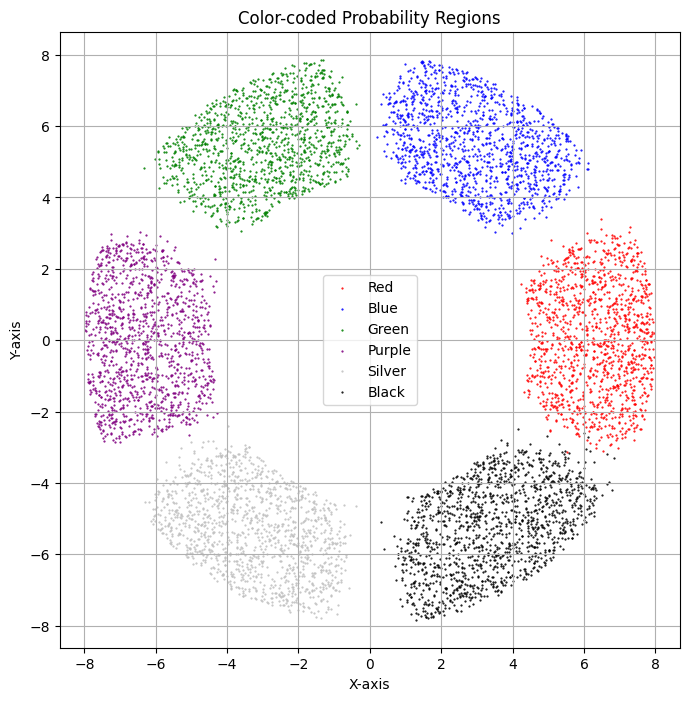

In [10]:
possible_coordinates = samples
red=[]
blue=[]
green=[]
purple=[]
silver=[]
black=[]
for x, y in tqdm(possible_coordinates):
    xy_tensor = torch.tensor([x, y], dtype=torch.float32, device=device)

    _, prob_red = infer_y_1(model, [1, 0, 0, 0, 0, 0], xy_tensor)
    _, prob_blue = infer_y_1(model, [0, 1, 0, 0, 0, 0], xy_tensor)
    _, prob_green = infer_y_1(model, [0, 0, 1, 0, 0, 0], xy_tensor)
    _, prob_purple = infer_y_1(model, [0, 0, 0, 1, 0, 0], xy_tensor)
    _, prob_silver = infer_y_1(model, [0, 0, 0, 0, 1, 0], xy_tensor)
    _, prob_black = infer_y_1(model, [0, 0, 0, 0, 0, 1], xy_tensor)

    if prob_red > prob_blue and prob_red > prob_green and prob_red > prob_purple and prob_red > prob_silver and prob_red > prob_black:
        red.append([x, y])
    elif prob_blue > prob_red and prob_blue > prob_green and prob_blue > prob_purple and prob_blue > prob_silver and prob_blue > prob_black:
        blue.append([x, y])
    elif prob_green > prob_red and prob_green > prob_blue and prob_green > prob_purple and prob_green > prob_silver and prob_green > prob_black:
        green.append([x, y])
    elif prob_purple > prob_red and prob_purple > prob_blue and prob_purple > prob_green and prob_purple > prob_silver and prob_purple > prob_black:
        purple.append([x, y])
    elif prob_silver > prob_red and prob_silver > prob_blue and prob_silver > prob_green and prob_silver > prob_purple and prob_silver > prob_black:
        silver.append([x, y])
    elif prob_black > prob_red and prob_black > prob_blue and prob_black > prob_green and prob_black > prob_purple and prob_black > prob_silver:
        black.append([x, y])



plt.figure(figsize=(8, 8))

if red:
    plt.scatter(*zip(*red), color='red', label='Red', s=0.3)
if blue:
    plt.scatter(*zip(*blue), color='blue', label='Blue', s=0.3)
if green:
    plt.scatter(*zip(*green), color='green', label='Green', s=0.3)
if purple:
    plt.scatter(*zip(*purple), color='purple', label='Purple', s=0.3)
if silver:
    plt.scatter(*zip(*silver), color='silver', label='Silver', s=0.3)
if black:
    plt.scatter(*zip(*black), color='black', label='Black', s=0.3)

plt.title('Color-coded Probability Regions')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.legend()
plt.grid(True)
plt.axis('equal')
plt.savefig('color_coded_probabilities.png')
plt.show()

# Generating new points

In [11]:
def infer_y_2(model, y_onehot, n_samples=1000, zeros_noise_scale=0.01):
    model.eval()

    if not isinstance(y_onehot, torch.Tensor):
        y_onehot = torch.tensor(y_onehot, dtype=torch.float32)

    y_onehot = y_onehot.to(device).repeat(n_samples, 1)

    pad_yz = zeros_noise_scale * torch.randn(n_samples, ndim_tot - ndim_y - ndim_z, device=device)
    z_samples = torch.randn(n_samples, ndim_z, device=device)

    y_rev = torch.cat((z_samples, pad_yz, y_onehot), dim=1)

    with torch.no_grad():
        x_samples = model(y_rev, rev=True)
        if isinstance(x_samples, tuple):
            x_samples = x_samples[0]

    x_generated = x_samples[:, :ndim_x]
    return x_generated.cpu().numpy()

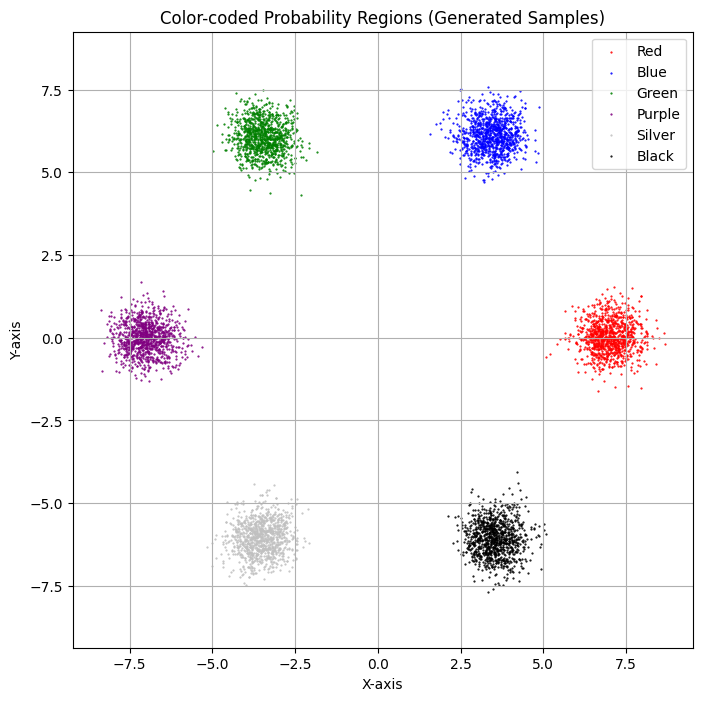

In [13]:
red_new = infer_y_2(model, [1, 0, 0, 0, 0, 0], n_samples=1000)
blue_new = infer_y_2(model, [0, 1, 0, 0, 0, 0], n_samples=1000)
green_new = infer_y_2(model, [0, 0, 1, 0, 0, 0], n_samples=1000)
purple_new = infer_y_2(model, [0, 0, 0, 1, 0, 0], n_samples=1000)
silver_new = infer_y_2(model, [0, 0, 0, 0, 1, 0], n_samples=1000)
black_new = infer_y_2(model, [0, 0, 0, 0, 0, 1], n_samples=1000)
plt.figure(figsize=(8, 8))
plt.scatter(red_new[:, 0], red_new[:, 1], color='red', label='Red', s=0.3)
plt.scatter(blue_new[:, 0], blue_new[:, 1], color='blue', label='Blue', s=0.3)
plt.scatter(green_new[:, 0], green_new[:, 1], color='green', label='Green', s=0.3)
plt.scatter(purple_new[:, 0], purple_new[:, 1], color='purple', label='Purple', s=0.3)
plt.scatter(silver_new[:, 0], silver_new[:, 1], color='silver', label='Silver', s=0.3)
plt.scatter(black_new[:, 0], black_new[:, 1], color='black', label='Black', s=0.3)
plt.title('Color-coded Probability Regions (Generated Samples)')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.legend()
plt.grid(True)
plt.axis('equal')
plt.savefig('color_coded_probabilities_generated.png')
plt.show()

# Generating animation
We generate an animation using infer_y_2

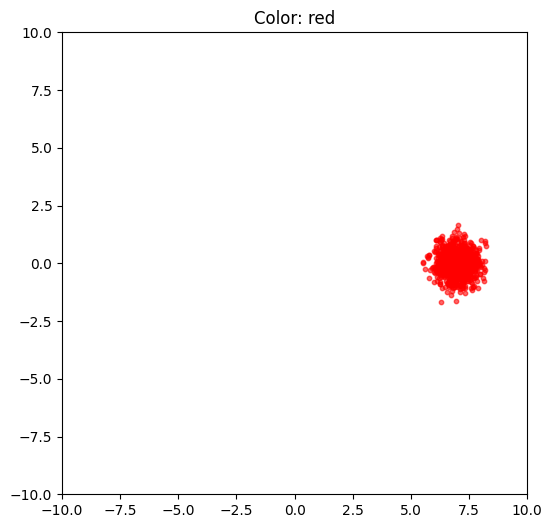

In [17]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
from IPython.display import HTML

# Color-label mappings
color_label_pairs = [
    ('red', [1, 0, 0, 0, 0, 0]),
    ('blue', [0, 1, 0, 0, 0, 0]),
    ('green', [0, 0, 1, 0, 0, 0]),
    ('purple', [0, 0, 0, 1, 0, 0]),
    ('silver', [0, 0, 0, 0, 1, 0]),
    ('black', [0, 0, 0, 0, 0, 1]),
]

fig, ax = plt.subplots(figsize=(6, 6))
sc = ax.scatter([], [], s=10, alpha=0.6)
title = ax.set_title("")

ax.set_xlim(-10, 10)
ax.set_ylim(-10, 10)

def update(frame):
    color, label = color_label_pairs[frame % len(color_label_pairs)]
    samples = infer_y_2(model, label, n_samples=1000)
    data = samples[:, :2]  # Assuming 2D output

    sc.set_offsets(data)
    sc.set_color(color)
    title.set_text(f"Color: {color}")
    return sc, title

ani = animation.FuncAnimation(fig, update, frames=len(color_label_pairs)*10, interval=1000, blit=False)

# Use this instead of plt.show() in Kaggle
HTML(ani.to_jshtml())
